In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import os 
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
%matplotlib inline
curr_dir = os.getcwd()

C:\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#get image file names:
nonvehicle_file_list = []
vehicle_file_list = []
for _dir,_,_ in os.walk(os.path.join(curr_dir, 'non-vehicles')):
    files = glob.glob(os.path.join(_dir,'*.png'))
    if len(files) > 0:
        nonvehicle_file_list.extend(f for f in files) 

for _dir,_,_ in os.walk(os.path.join(curr_dir, 'vehicles')):
    files = glob.glob(os.path.join(_dir,'*.png'))
    if len(files) > 0:
        vehicle_file_list.extend(f for f in files)

print("Number of non-vehicle images : ", len(nonvehicle_file_list))
print("Number of vehicle images : ", len(vehicle_file_list))
num_images_nonveh = len(nonvehicle_file_list)
num_images_veh = len(vehicle_file_list)

Number of non-vehicle images :  8968
Number of vehicle images :  8792


In [3]:
#get images from vehicle and non-vehicle set  (read in RGB) and save them to pickle
nonvehicle_images = []
vehicle_images = []

for nvf in nonvehicle_file_list:
    nonvehicle_images.append(cv2.cvtColor(cv2.imread(nvf),cv2.COLOR_BGR2RGB))

for vf in vehicle_file_list:
    vehicle_images.append(cv2.cvtColor(cv2.imread(vf),cv2.COLOR_BGR2RGB))

pickle.dump(np.asarray(nonvehicle_images,np.uint8), open(os.path.join(curr_dir,"nonvehicle_rgb.p"),'wb'))
pickle.dump(np.asarray(vehicle_images,np.uint8), open(os.path.join(curr_dir,"vehicle_rgb.p"),'wb'))

In [4]:
#load from pickle (just for testing)
NON_VEHICLE_DATA = pickle.load( open( "nonvehicle_rgb.p", "rb" ) )
VEHICLE_DATA = pickle.load( open( "vehicle_rgb.p", "rb" ) )
num_images_nonveh = len(NON_VEHICLE_DATA)
num_images_veh = len(VEHICLE_DATA)
print(num_images_nonveh)
print(num_images_veh)
print(NON_VEHICLE_DATA.shape)

8968
8792
(8968, 64, 64, 3)


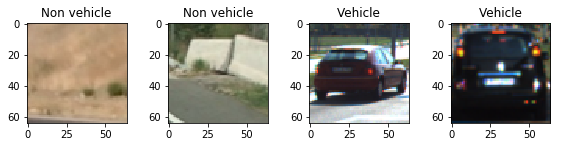

In [5]:
#show random images from dataset. (2 from each label)
nonveh_samples = NON_VEHICLE_DATA[np.random.randint(0, num_images_nonveh, 2)]
veh_samples = VEHICLE_DATA[np.random.randint(0, num_images_veh, 2)]

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8, 3))
f.tight_layout()
ax1.imshow(nonveh_samples[0])
ax1.set_title('Non vehicle')
ax2.imshow(nonveh_samples[1])
ax2.set_title('Non vehicle')
ax3.imshow(veh_samples[0])
ax3.set_title('Vehicle')
ax4.imshow(veh_samples[1])
ax4.set_title('Vehicle')

In [6]:
#spatial feature extraction function, from lecture:

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

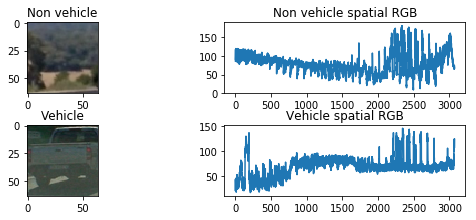

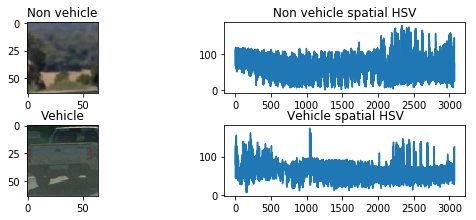

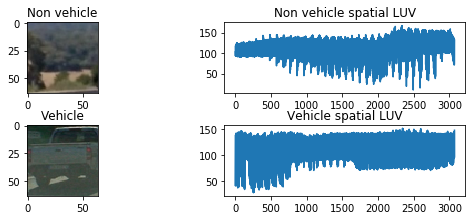

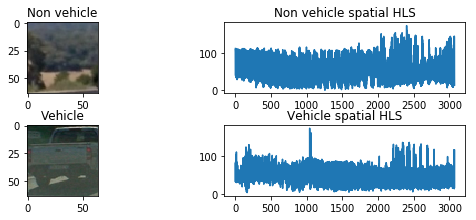

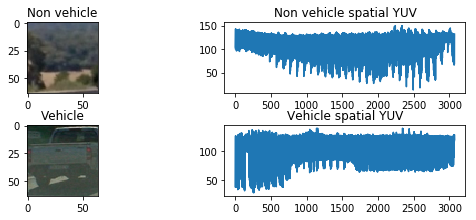

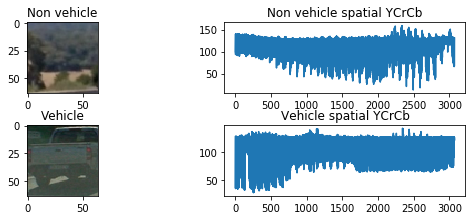

In [7]:
#visualize spatial feature for one sample image from each label, for each colorspace:
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
nonveh_sample = NON_VEHICLE_DATA[np.random.randint(0, num_images_nonveh)]
veh_sample = VEHICLE_DATA[np.random.randint(0, num_images_veh)]
for cspace in color_spaces:
    nv_feature = bin_spatial(nonveh_sample, cspace)
    v_feature = bin_spatial(veh_sample, cspace)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 3))
    f.tight_layout()
    ax1.imshow(nonveh_sample)
    ax1.set_title('Non vehicle')
    ax2.plot(nv_feature)
    ax2.set_title('Non vehicle spatial ' + cspace)
    ax3.imshow(veh_sample)
    ax3.set_title('Vehicle')
    ax4.plot(v_feature)
    ax4.set_title('Vehicle spatial ' + cspace)

In [8]:
#color hist feature extractor from lecture:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

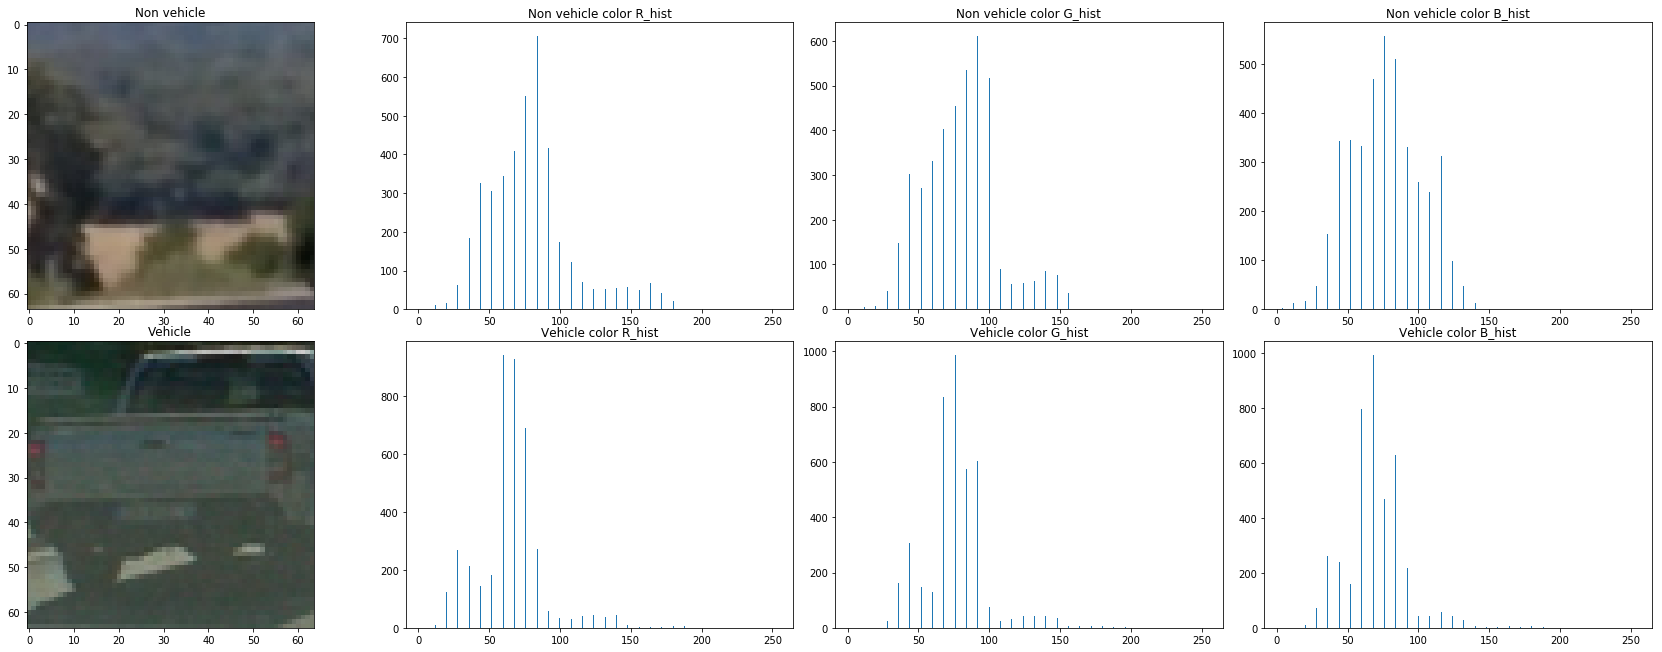

In [9]:
#visualize color features for the sample images from previous cells:

[rhist, ghist, bhist, bin_centers, hist_features] = color_hist(nonveh_sample) #use default values

f, ((axNVim, axNV_R, axNV_G, axNV_B), (axVim, axV_R, axV_G, axV_B)) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()
axNVim.imshow(nonveh_sample)
axNVim.set_title('Non vehicle')
axNV_R.bar(bin_centers, rhist[0])
axNV_R.set_title('Non vehicle color ' + 'R_hist')
axNV_G.bar(bin_centers, ghist[0])
axNV_G.set_title('Non vehicle color ' + 'G_hist')
axNV_B.bar(bin_centers, bhist[0])
axNV_B.set_title('Non vehicle color ' + 'B_hist')

[rhist, ghist, bhist, bin_centers, hist_features] = color_hist(veh_sample)
axVim.imshow(veh_sample)
axVim.set_title('Vehicle')
axV_R.bar(bin_centers, rhist[0])
axV_R.set_title('Vehicle color ' + 'R_hist')
axV_G.bar(bin_centers, ghist[0])
axV_G.set_title('Vehicle color ' + 'G_hist')
axV_B.bar(bin_centers, bhist[0])
axV_B.set_title('Vehicle color ' + 'B_hist')

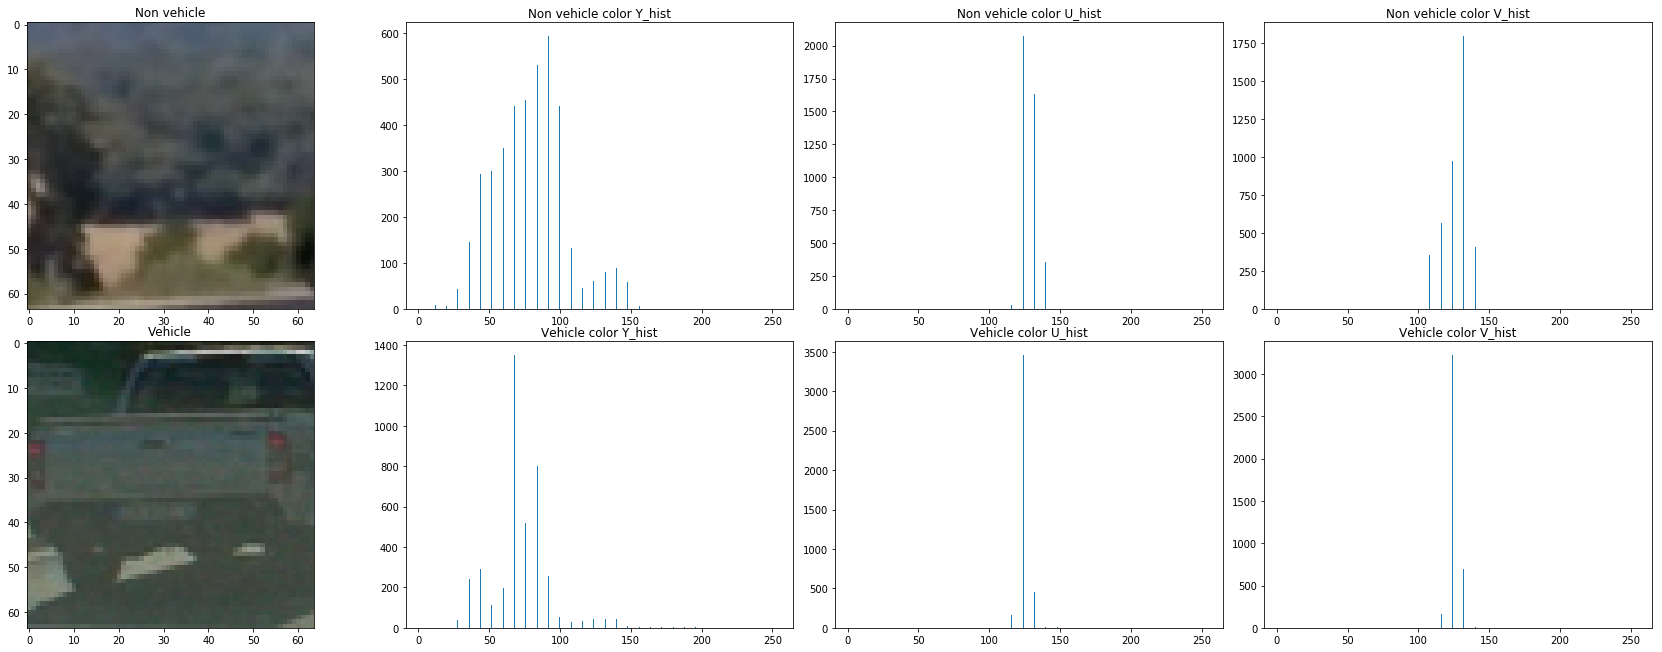

In [10]:
#visualize color features for the sample images from previous cells with YUV colorspace:

[rhist, ghist, bhist, bin_centers, hist_features] = color_hist(
    cv2.cvtColor(nonveh_sample,cv2.COLOR_RGB2YUV)) 

f, ((axNVim, axNV_R, axNV_G, axNV_B), (axVim, axV_R, axV_G, axV_B)) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()
axNVim.imshow(nonveh_sample)
axNVim.set_title('Non vehicle')
axNV_R.bar(bin_centers, rhist[0])
axNV_R.set_title('Non vehicle color ' + 'Y_hist')
axNV_G.bar(bin_centers, ghist[0])
axNV_G.set_title('Non vehicle color ' + 'U_hist')
axNV_B.bar(bin_centers, bhist[0])
axNV_B.set_title('Non vehicle color ' + 'V_hist')

[rhist, ghist, bhist, bin_centers, hist_features] = color_hist(
    cv2.cvtColor(veh_sample,cv2.COLOR_RGB2YUV)) #use default values
axVim.imshow(veh_sample)
axVim.set_title('Vehicle')
axV_R.bar(bin_centers, rhist[0])
axV_R.set_title('Vehicle color ' + 'Y_hist')
axV_G.bar(bin_centers, ghist[0])
axV_G.set_title('Vehicle color ' + 'U_hist')
axV_B.bar(bin_centers, bhist[0])
axV_B.set_title('Vehicle color ' + 'V_hist')

In [11]:
#function for extracting hog features. (from lecture notes):

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

C:\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.379297219726


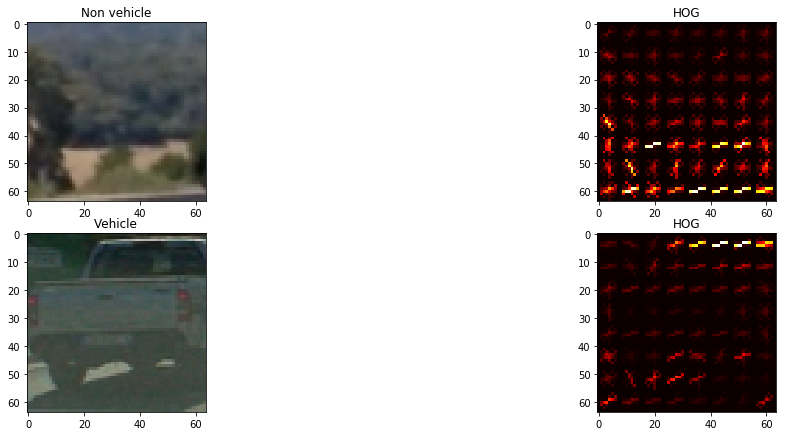

In [12]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

[f_v, h_v] = get_hog_features(cv2.cvtColor(veh_sample,cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
[f_nv, h_nv] = get_hog_features(cv2.cvtColor(nonveh_sample,cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
print(np.max(f_v))
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(nonveh_sample)
ax1.set_title('Non vehicle')
ax2.imshow(h_nv, cmap='hot')
ax2.set_title('HOG')
ax3.imshow(veh_sample)
ax3.set_title('Vehicle')
ax4.imshow(h_v, cmap='hot')
ax4.set_title('HOG')

In [13]:
#extract features from single image (code taken from lecture notes and modified):

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        # do not need specific histograms here, just the feature list
        _0, _1, _2, _3, hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        hog_np = np.asarray(hog_features)
        img_features.append(hog_np)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

C:\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


shape of feature vector stack: (2, 8460)


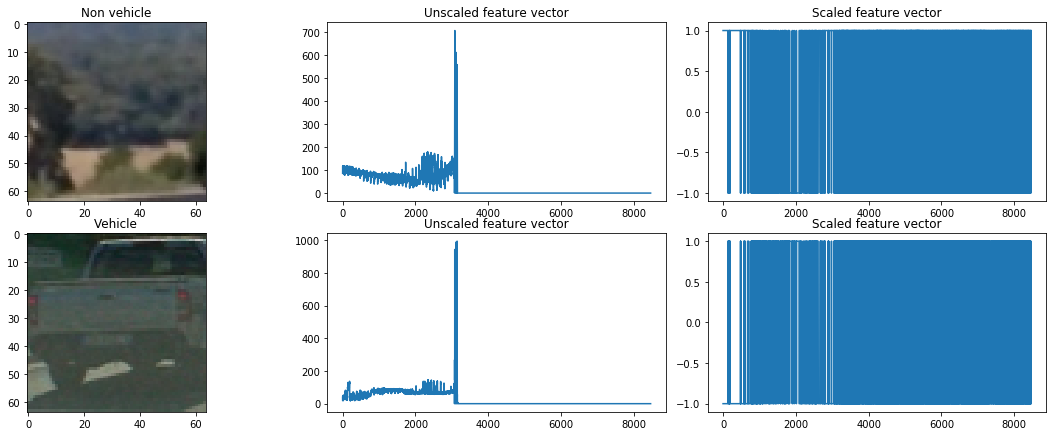

In [14]:
# Visualize features in scaled and non-scaled form, use only samples above
# just a sanity check for scaling step...

# get feature vector for non-vehicle image:
non_veh_feature = single_img_features(nonveh_sample, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True)
# get feature vector for vehicle image:
veh_feature = single_img_features(veh_sample, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True)


one_sample_data = np.vstack([non_veh_feature, veh_feature]).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(one_sample_data)
# Apply the scaler to X
scaled_X = X_scaler.transform(one_sample_data)
print('shape of feature vector stack:', scaled_X.shape)
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 6))
f.tight_layout()
ax1.imshow(nonveh_sample)
ax1.set_title('Non vehicle')
ax2.plot(np.linspace(0,len(non_veh_feature)-1,len(non_veh_feature)),non_veh_feature)
ax2.set_title('Unscaled feature vector')
ax3.plot(np.linspace(0,len(non_veh_feature)-1,len(non_veh_feature)), scaled_X[0])
ax3.set_title('Scaled feature vector')
ax4.imshow(veh_sample)
ax4.set_title('Vehicle')
ax5.plot(np.linspace(0,len(veh_feature)-1,len(veh_feature)), veh_feature)
ax5.set_title('Unscaled feature vector')
ax6.plot(np.linspace(0,len(veh_feature)-1,len(veh_feature)), scaled_X[1])
ax6.set_title('Scaled feature vector')

###  extract features function from lecture notes
will be used to extract features from sample dataset and train the classifier

In [26]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' #0 # Can be 0, 1, 2, or "ALL"
spatialSize = (32,32)
HISTBINS = 32
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        image = cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            #print('spatial features type: ', type(spatial_features) )
        if hist_feat == True:
            # Apply color_hist()
            _0, _1, _2, _3, hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            #print('hist features type: ', type(hist_features) )
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            hog_np = np.asarray(hog_features)
            file_features.append(hog_np)
            #print('hog features type: ', type(hog_np) )
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [16]:
try:
    del VEHICLE_DATA
    del NON_VEHICLE_DATA
except Exception:
    print('values already deleted')
nonveh_samples = np.asarray(nonvehicle_file_list)[np.random.randint(0, num_images_nonveh-1, num_images_nonveh)]
veh_samples = np.asarray(vehicle_file_list)[np.random.randint(0, num_images_veh-1, num_images_veh)]
#nonveh_samples = np.asarray(nonvehicle_file_list)[np.random.randint(0, num_images_nonveh-1, 5000)]
#veh_samples = np.asarray(vehicle_file_list)[np.random.randint(0, num_images_veh-1, 5000)]

# Training of Classifier

In [17]:
import time
from sklearn.calibration import CalibratedClassifierCV

t=time.time()
car_features = extract_features(veh_samples, cspace=colorspace, spatial_size=spatialSize, 
                                hist_bins=HISTBINS, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(nonveh_samples, cspace=colorspace, spatial_size=spatialSize, 
                                   hist_bins=HISTBINS, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract all features...')

# Create an array stack of feature vectors
X = np.vstack([car_features, notcar_features]).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler(copy=False).fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc_m = LinearSVC()
svc = CalibratedClassifierCV(svc_m)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

C:\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


73.76 Seconds to extract all features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
92.8 Seconds to train SVC...
Test Accuracy of SVC =  0.9969
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
0.008 Seconds to predict 10 labels with SVC


In [18]:
# save classifier to pickle:
pickle.dump(svc, open(os.path.join(curr_dir,"svc_pickle_rgb_corrected.p"),'wb'))
pickle.dump(X_scaler, open(os.path.join(curr_dir,"scaler_rgb_corrected.p"),'wb'))

In [17]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), window_list =[]):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    #window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [18]:
mtx = pickle.load( open( "cal_mtx.p", "rb" ) )
dist = pickle.load( open( "cal_dist.p", "rb" ) )

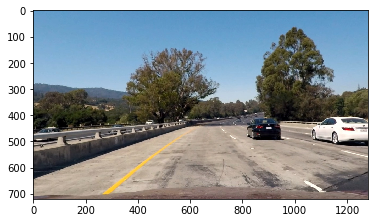

In [19]:
img = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'),cv2.COLOR_BGR2RGB)
undistorted_test = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undistorted_test)

In [20]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

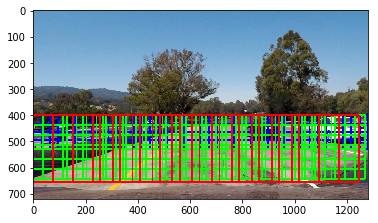

In [21]:
up = 400
down = up + 256
up_left = (0, up)
up_right = (1280, up)
down_left = (0, down)
down_right = (1280, down)
window_try = []
window_try = slide_window(img, y_start_stop=[up,up+128], xy_overlap=(0.5,0.5))
level1 = draw_boxes(img, window_try)
window_try = []
window_try = slide_window(img, y_start_stop=[up,up+256],xy_window=(128,128), xy_overlap=(0.7,0.7),window_list=window_try)
level2 = draw_boxes(level1, window_try, color = (0,255,0))
window_try = []
window_try = slide_window(img, y_start_stop=[up,down],xy_window=(256,256), xy_overlap=(0.7,0.7),window_list=window_try)
plt.imshow(draw_boxes(level2,window_try, color=(255,0,0)))
#for w in window_try:
 #   boxes.append([(x,ystart),(x+boxsize,ystart+boxsize)])


In [22]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# Mainly from lecture notes, small modifications on return value and some parameters
# uses prediction probabilities instead of prediction  
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #NOT NEEDED IMAGES ARE READ BY CV2
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            _0, _1, _2, _3, hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [23]:
### MODIFIED
# Mainly from lecture notes, small modifications on return value and some parameters
# uses prediction probabilities instead of prediction  
def find_cars2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
     #NOT NEEDED IMAGES ARE READ BY CV2
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    output_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            _0, _1, _2, _3, hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            #use prediction probability instead of predicted label:
            test_prediction = svc.predict_proba(test_features)
            
            if test_prediction[0][1] > 0.85:
                #print("found")
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                output_windows.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return output_windows

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
#image = mpimg.imread('test_image.jpg')
#heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


C:\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


78  cars found
0  cars found
11  cars found
67  cars found
56  cars found
113  cars found


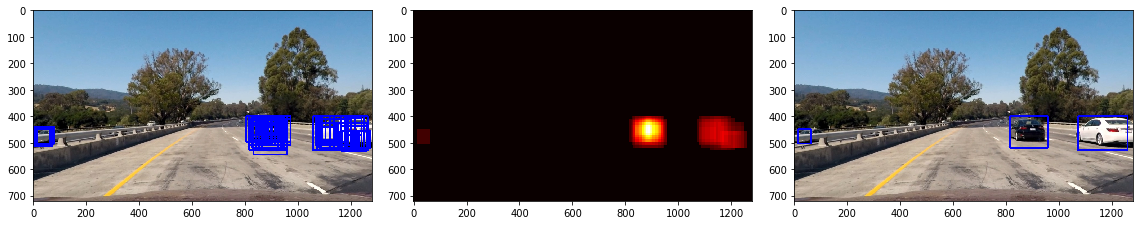

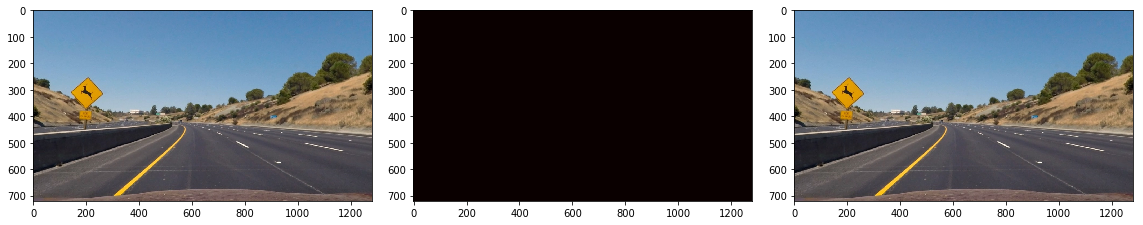

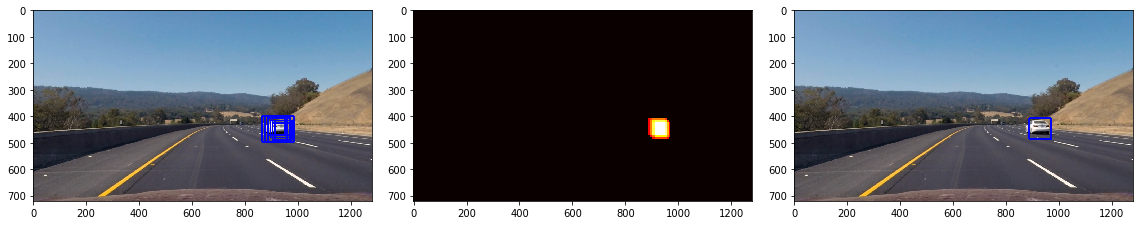

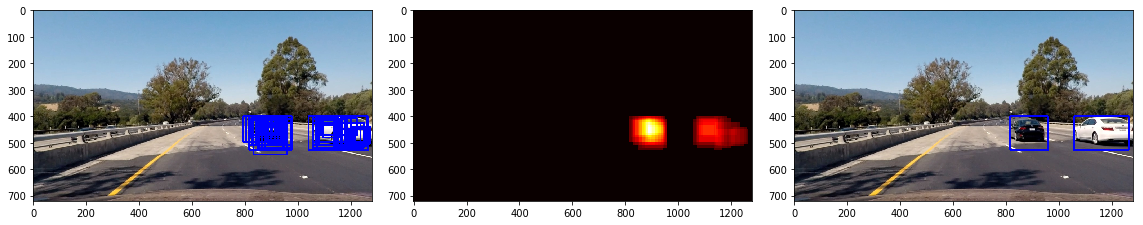

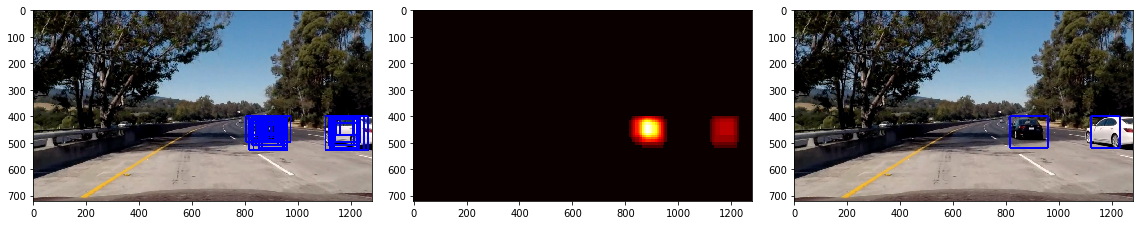

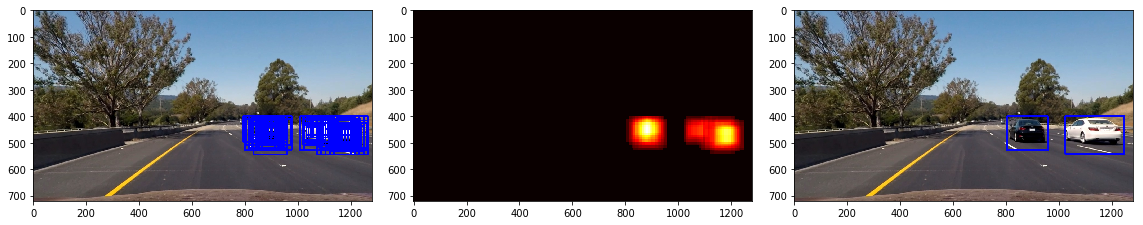

In [27]:
mysvc = pickle.load( open( "svc_pickle_rgb_corrected.p", "rb" ) )
X_scaler = pickle.load(open("scaler_rgb_corrected.p", "rb"))
directory = os.path.join(curr_dir, 'test_images')

for file in os.listdir(directory):
    filename = os.path.join(curr_dir, 'test_images', os.fsdecode(file))
    if not filename.endswith('jpg'):
        continue
    img = cv2.imread(filename)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistorted_test = cv2.undistort(img_rgb, mtx, dist, None, mtx)
    carz = []
    carz = find_cars2(undistorted_test, up, up+256, scale=1, svc=mysvc, X_scaler=X_scaler, orient=orient, pix_per_cell=8, 
              cell_per_block=2, spatial_size=spatialSize, hist_bins=HISTBINS)
    carz.extend(
        find_cars2(undistorted_test, up, up+256, scale=1.5, svc=mysvc, X_scaler=X_scaler, orient=orient, pix_per_cell=8, 
              cell_per_block=2, spatial_size=spatialSize, hist_bins=HISTBINS)
    )
    carz.extend(
        find_cars2(undistorted_test, up, up+256, scale=2, svc=mysvc, X_scaler=X_scaler, orient=orient, pix_per_cell=8, 
              cell_per_block=2, spatial_size=spatialSize, hist_bins=HISTBINS)
    )
    carz.extend(
        find_cars2(undistorted_test, up, up+256, scale=4, svc=mysvc, X_scaler=X_scaler, orient=orient, pix_per_cell=8, 
              cell_per_block=2, spatial_size=spatialSize, hist_bins=HISTBINS)
    )
    print(len(carz), ' cars found')
    
    heat = np.zeros_like(undistorted_test[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, carz)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(undistorted_test), labels)
    
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
    f.tight_layout()
    ax1.imshow(draw_boxes(undistorted_test, carz))
    ax2.imshow(heatmap,'hot')
    ax3.imshow(draw_img)

## Class definitions for processing the video with the above pipeline

In [32]:
from collections import deque
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

class HeatMap:
    '''
    class for heatmap calculations
    uses a dequeue for averaging over consecutive frames
    '''
    def __init__(self, threshold = 0):
        self.heatmap_history = deque(maxlen = 5)
        self.current_heatmap = None
        self.accumulated_heatmap = None
        self.threshold = threshold
    
    def set_threshold(self, value):
        self.threshold = value
    
    def add_heat(self, img, bbox_list):
        self.current_heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.current_heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
        self.heatmap_history.append(self.current_heatmap)
        self.accumulated_heatmap = np.zeros_like(self.current_heatmap, np.float64)
        #print(np.max(self.accumulated_heatmap))
        for h in self.heatmap_history:
            self.accumulated_heatmap += h
        self.accumulated_heatmap /= len(self.heatmap_history)
        
        
    def get_heat(self):
        return self.apply_threshold(self.accumulated_heatmap)
    
    def get_labels(self):   
        return label(self.get_heat())
        
    def apply_threshold(self, hm):
        # Zero out pixels below the threshold
        hm[hm <= self.threshold] = 0
        # Return thresholded map
        return hm
    
    def get_labeled_boxes(self, labels):
        boxes_list = []
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            boxes_list.append(bbox)
        return boxes_list
    
    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img

In [33]:
global WINDOWSLIST 
class VehicleDetector:
    '''
    main class responsible for processing video according to the pipeline, in order to detect vehicles
    '''
    def __init__(self, svc_file_name, scaler_file_name):
        # load saved sv classifier:
        self.svc = pickle.load( open( svc_file_name, "rb" ) )
        # load the scaler:
        self.scaler = pickle.load(open(scaler_file_name, "rb"))
        
        #get transformation values for undistortion of images:
        self.mtx = pickle.load( open( "cal_mtx.p", "rb" ) )
        self.dist = pickle.load( open( "cal_dist.p", "rb" ) ) 
        
        #obj for heatmap calculations:
        self.heatmap = HeatMap(threshold=2.0)
        
        #will store the undistorted form of input image
        self.undistorted = None
        
        #define scaling of search windows for find_cars
        self.search_scales = [1, 1.5, 2, 4]
        
        # sliding step for find_cars
        self.cellsperstep = 1
        
        # probability threshold for car prediction
        self.prediction_prob_thres = 0.9
        
        #field to store detected boxes on a blank image
        self.output_boxes = None
        
        #parameters used during training shall be used here (better way- save to dump and load all together):
        self.colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL' #0 # Can be 0, 1, 2, or "ALL"
        self.spatialSize = (32,32)
        self.HISTBINS = 32
        # y coordinate to start window sliding:
        self.up = 400
        # field to store windows where cars are detected by classifier:
        self.car_windows = []
        self.output_img = None
        self.frame_counter = 0
    ### MODIFIED
    # Mainly from lecture notes, small modifications on return value and some parameters
    # uses prediction probabilities instead of prediction  
    def find_cars(self, img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

        draw_img = np.copy(img)
         #NOT NEEDED IMAGES ARE READ BY CV2
        #img = img.astype(np.float32)/255

        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = self.cellsperstep  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                _0, _1, _2, _3, hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

                #use prediction probability instead of predicted label:
                test_prediction = svc.predict_proba(test_features)

                if test_prediction[0][1] > self.prediction_prob_thres:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    self.car_windows.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])

    def process(self, img_rgb):
        # expects RGB image!!!
        self.undistorted = cv2.undistort(img_rgb, self.mtx, self.dist, None, self.mtx)
        #process every third frame for speeding up. (just a hack) --> period becomes ~0.125s
        self.frame_counter +=1
        if (self.frame_counter % 3) != 1:
            return draw_boxes(self.undistorted, self.heatmap.get_labeled_boxes(self.labels))
        
        #clear car windows list:
        self.car_windows = []
        
        #search for cars, with different scales. i.e. windows of sizes (64,64),(96,96), (128,128), (256,256)
        self.find_cars(self.undistorted, self.up, self.up+256, scale=1, svc=self.svc, X_scaler=self.scaler, 
                       orient=self.orient, pix_per_cell=self.pix_per_cell, cell_per_block=self.cell_per_block, 
                       spatial_size=self.spatialSize, hist_bins=self.HISTBINS)
        self.find_cars(self.undistorted, self.up, self.up+256, scale=1.5, svc=self.svc, X_scaler=self.scaler, 
                       orient=self.orient, pix_per_cell=self.pix_per_cell, cell_per_block=self.cell_per_block, 
                       spatial_size=self.spatialSize, hist_bins=self.HISTBINS)
        self.find_cars(self.undistorted, self.up, self.up+256, scale=2, svc=self.svc, X_scaler=self.scaler, 
                       orient=self.orient, pix_per_cell=self.pix_per_cell, cell_per_block=self.cell_per_block, 
                       spatial_size=self.spatialSize, hist_bins=self.HISTBINS)
        self.find_cars(self.undistorted, self.up, self.up+256, scale=4, svc=self.svc, X_scaler=self.scaler, 
                       orient=self.orient, pix_per_cell=self.pix_per_cell, cell_per_block=self.cell_per_block, 
                       spatial_size=self.spatialSize, hist_bins=self.HISTBINS)
        
        self.heatmap.add_heat(self.undistorted, self.car_windows)
        #WINDOWSLIST.append(self.car_windows)
        self.labels = self.heatmap.get_labels()
        
        #self.output_boxes = self.heatmap.draw_labeled_bboxes(self.undistorted, labels)
        #self.output_img = cv2.addWeighted(self.undistorted, 1, self.output_boxes, 1, 0)
        
        return self.heatmap.draw_labeled_bboxes(self.undistorted, self.labels)
 

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

output = os.path.join(curr_dir, 'project_output.mp4')

vp = VehicleDetector("svc_pickle_rgb_corrected.p","scaler_rgb_corrected.p")

clip1 = VideoFileClip(os.path.join(curr_dir,"project_video.mp4"))#.subclip(0,15)
#clip1 = VideoFileClip(os.path.join(curr_dir,"test_video.mp4"))
clip = clip1.fl_image(vp.process) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video C:\Users\Public\Personal\carnd1-VehicleDetection\project_output.mp4
[MoviePy] Writing video C:\Users\Public\Personal\carnd1-VehicleDetection\project_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [37:04<00:02,  2.94s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\Public\Personal\carnd1-VehicleDetection\project_output.mp4 

Wall time: 37min 4s


In [31]:

HTML("""
<video width="960" height="540" controls>
  <source src="deneme.mp4">
</video>
""")

test1.jpg
test2.jpg
test3.jpg
test4.jpg
test5.jpg
test6.jpg


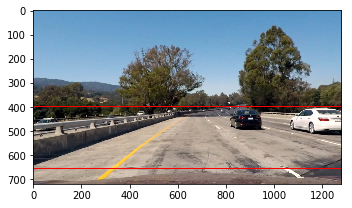

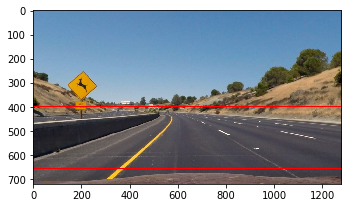

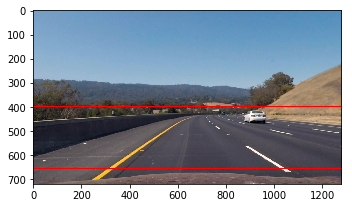

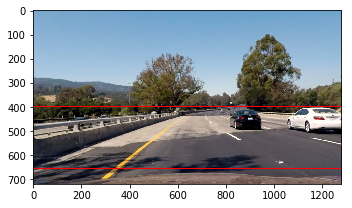

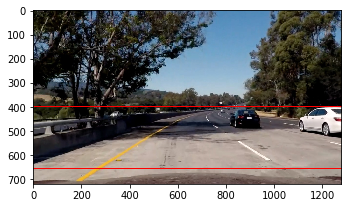

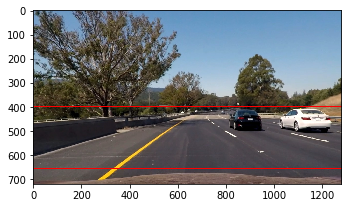

In [19]:
up = 400
down = up + 256
up_left = (0, up)
up_right = (1280, up)
down_left = (0, down)
down_right = (1280, down)


for filename in os.listdir(os.path.join(curr_dir, 'test_images')):
    if not 'jpg' in filename:
        continue
    print(filename)
    orig = cv2.cvtColor(cv2.imread(os.path.join(curr_dir, 'test_images', filename)),cv2.COLOR_BGR2RGB)
    undistorted = cv2.undistort(orig, mtx, dist, None, mtx)
    
    cv2.line(undistorted, up_left, up_right, (255,0,0), 4)
    cv2.line(undistorted, down_left, down_right, (255,0,0), 4)
    f, (ax1) = plt.subplots(1, 1, figsize=(8, 3))
    f.tight_layout()
    ax1.imshow(undistorted)